## Import libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input

## Parameters

In [2]:
n_timestep = 3 # Số time step
n_timepred = 3# số ngày dự đoán
n_feature = 6 # Số thuộc tính của mỗi timestep
train_val_test_rate = (0.75, 0.125, 0.125) # Tập dữ liệu có 8 năm, dành 6 năm để train, 1 năm để tối ưu và 1 năm để test

## Load Dataset

In [101]:
dataset = pd.read_csv('processed_data/dataset.csv', index_col='date', parse_dates=True)
unnoise_dataset = pd.read_csv('processed_data/unnoise_dataset.csv', index_col='date', parse_dates=True)

In [102]:
dataset.head()

,Ttb,Tx,Tn,R,Utb,Un
date,,,,,,
2014-01-01,12.8,23.0,6.5,0.0,75.0,39.0
2014-01-02,14.0,23.0,7.6,0.0,75.0,43.0
2014-01-03,16.7,25.3,10.6,0.0,75.0,43.0
2014-01-04,16.2,24.4,75.8,0.0,76.0,36.0
2014-01-05,15.6,22.6,10.0,0.0,74.0,49.0


In [103]:
unnoise_dataset.head()

,Ttb,Tx,Tn,R,Utb,Un
date,,,,,,
2014-01-01,12.8,23.0,6.5,0.0,75.0,39.0
2014-01-02,14.0,23.0,7.6,0.0,75.0,43.0
2014-01-03,16.2,24.4,10.6,0.0,75.0,43.0
2014-01-04,16.2,24.4,10.6,0.0,75.0,43.0
2014-01-05,16.2,22.6,15.5,0.0,76.0,49.0


## Generate Dataset

### Scaling

In [104]:
from sklearn.preprocessing import MinMaxScaler

In [105]:
scaler = MinMaxScaler()
scaled_unnoise_dataset = scaler.fit_transform(unnoise_dataset)

In [106]:
scaled_unnoise_dataset[:5]

array([[0.24390244, 0.47766323, 0.16666667, 0.        , 0.43373494,
        0.18055556],
       [0.29268293, 0.47766323, 0.21031746, 0.        , 0.43373494,
        0.23611111],
       [0.38211382, 0.5257732 , 0.32936508, 0.        , 0.43373494,
        0.23611111],
       [0.38211382, 0.5257732 , 0.32936508, 0.        , 0.43373494,
        0.23611111],
       [0.38211382, 0.46391753, 0.52380952, 0.        , 0.45783133,
        0.31944444]])

### Train-val-test split

In [107]:
def train_val_test_split(data, rate=(0.6, 0.2, 0.2)):
    idx_train = int(rate[0] * len(data))
    idx_val = int((rate[1] + rate[0]) * len(data))
    return np.array(data[:idx_train]), np.array(data[idx_train:idx_val]), np.array(data[idx_val:]), idx_train, idx_val


In [108]:
train_set, val_set, test_set, idx_train, idx_val = train_val_test_split(data=scaled_unnoise_dataset, rate=train_val_test_rate)

In [109]:
train_set.shape, test_set.shape

((2191, 6), (366, 6))

### Timestep split

In [110]:
def timestep_split(data, n_step):
    X, y = [], []
    
    length = len(data)
    for i in range(length - n_step):
        end_idx = i + n_step
        seq_X = data[i:end_idx]
        seq_y = data[end_idx]
        X.append(seq_X)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [111]:
X_train, y_train = timestep_split(data=train_set, n_step=n_timestep)
X_val, y_val = timestep_split(data=val_set, n_step=n_timestep)
X_test, y_test = timestep_split(data=test_set, n_step=n_timestep)

In [112]:
X_train.shape, X_test.shape

((2188, 3, 6), (363, 3, 6))

## Build model

In [5]:
model = Sequential()

model.add(Input(shape=(n_timestep, n_feature), name='Input'))

model.add(SimpleRNN(units=64,
                    activation='tanh',
                    use_bias=True,
                    kernel_initializer='glorot_uniform',
                    recurrent_initializer='orthogonal',
                    bias_initializer='zeros',
                    dropout=0.0,
                    recurrent_dropout=0.0,
                    return_sequences=True,
                    name='RNN_many_to_many'))

model.add(SimpleRNN(units=64,
                    activation='tanh',
                    use_bias=True,
                    kernel_initializer='glorot_uniform',
                    recurrent_initializer='orthogonal',
                    bias_initializer='zeros',
                    dropout=0.0,
                    recurrent_dropout=0.0,
                    name='RNN_many_to_one'))

model.add(Dense(units=n_feature,
                activation='sigmoid',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                name='Output_layer'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001,
                               beta_1=0.9,
                               beta_2=0.999,
                               epsilon=1e-08)

model.compile(optimizer=opt, loss='mse')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RNN_many_to_many (SimpleRNN  (None, 3, 64)            4544      
 )                                                               
                                                                 
 RNN_many_to_one (SimpleRNN)  (None, 64)               8256      
                                                                 
 Output_layer (Dense)        (None, 6)                 390       
                                                                 
Total params: 13,190
Trainable params: 13,190
Non-trainable params: 0
_________________________________________________________________


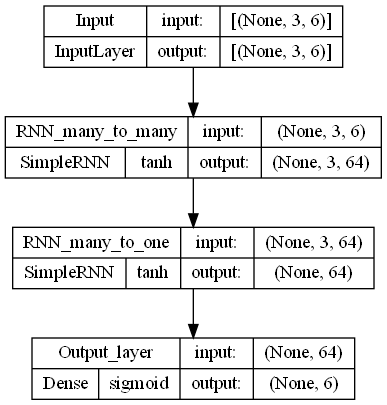

In [6]:
keras.utils.plot_model(model, to_file='image/RNN_model.png', show_shapes=True, show_layer_activations=True, show_layer_names=True)

## Train

In [115]:
path = 'model/RNN_model_3timesteps.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath=path, monitor='val_loss', save_best_only=True) # checkpoint callbacks

In [116]:
model.fit(X_train, y_train, epochs=50, verbose=0, callbacks=[checkpoint], batch_size=4,
         validation_data=(X_val, y_val), validation_batch_size=4)

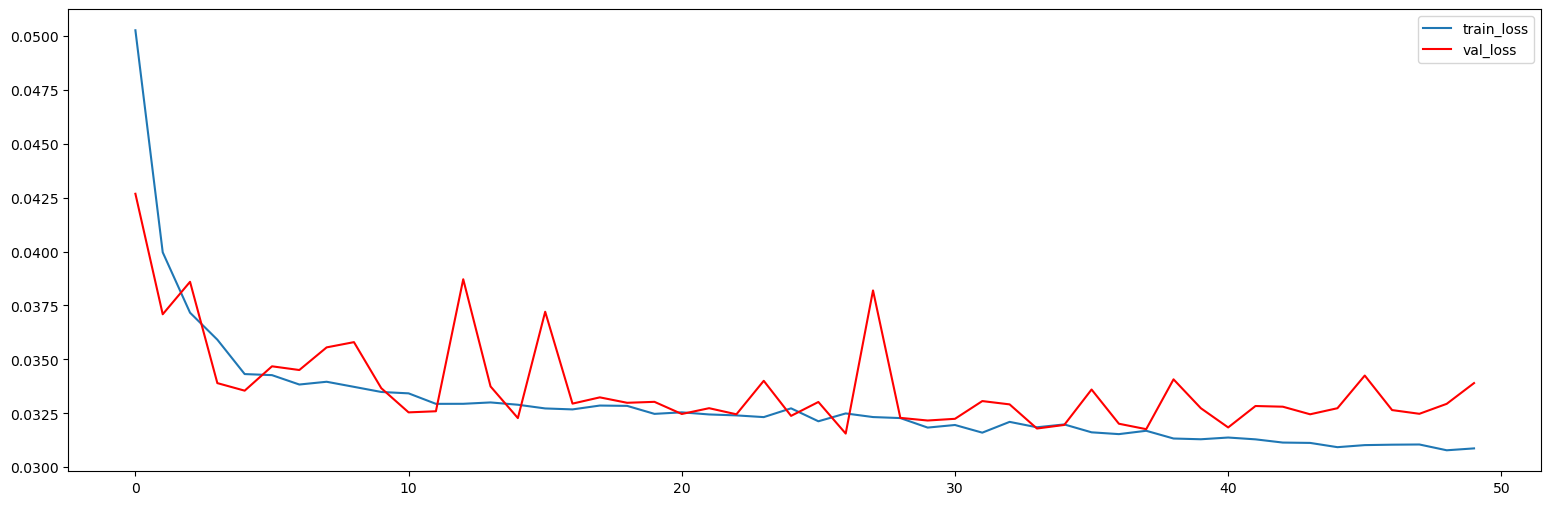

In [117]:
plt.figure(figsize=(19, 6))
plt.plot(model.history.history['loss'], label='train_loss')
plt.plot(model.history.history['val_loss'], c='red', label='val_loss')
plt.legend();

## Evaluate

In [118]:
#load best model
model = keras.models.load_model('model/RNN_model_3timesteps.h5')

In [119]:
def predict(model, X, n_pred=1):
    pred = []
    length = len(X)
    for idx in range(0, length - n_pred, n_pred):
        X_i = X[idx][None]
        for i in range(n_pred):
            y_i = model.predict(X_i, verbose=0)
            pred.append(y_i) # thêm kết quả dự đoán vào pred[]
            if y_i[0][3] < 0.5:
                y_i[0][3] = 0
            else:
                y_i[0][3] = 1
            X_i = np.append(X_i[0], y_i, axis=0)[None] # thêm output vừa thu được vào input
            X_i = X_i[:,1:,:] # cắt bỏ timestep đầu tiên
    if length%n_pred == 0:
        n = length - n_pred
    else:
        n = length - length%n_pred
    return np.array(pred).reshape(n, n_feature)

In [120]:
#get predict
y_predict = predict(model, X_test, n_pred=n_timepred)

y_predict = scaler.inverse_transform(y_predict)
y_unnoise = scaler.inverse_transform(y_test) #unnoised

In [121]:
Ttb_pred, Tx_pred, Tn_pred, R_pred, Utb_pred, Un_pred = y_predict[:,0], y_predict[:,1], y_predict[:,2], y_predict[:,3], y_predict[:,4], y_predict[:,5]

start_idx = n_timestep
end_idx = (len(y_test) - len(y_test)%n_timepred) if len(y_test)%n_timepred != 0 else (len(y_test) - n_timepred)

y_unnoise = y_unnoise[:end_idx, :]
Ttb_unnoise, Tx_unnoise, Tn_unnoise, R_unnoise, Utb_unnoise, Un_unnoise = y_unnoise[:,0], y_unnoise[:,1], y_unnoise[:,2], y_unnoise[:,3], y_unnoise[:,4], y_unnoise[:,5]

_, _, y_real_test, _, _ = train_val_test_split(data=dataset, rate=train_val_test_rate)
y_real_test = y_real_test[ start_idx : end_idx+start_idx , : ]
Ttb_real, Tx_real, Tn_real, R_real, Utb_real, Un_real = y_real_test[:,0], y_real_test[:,1], y_real_test[:,2], y_real_test[:,3], y_real_test[:, 4], y_real_test[:,5]

### Ttb (Nhiệt độ trung bình)

In [122]:
from keras.metrics import mean_absolute_error

In [123]:
# mean absolute error
Ttb_mae_1 = float(mean_absolute_error(Ttb_unnoise, Ttb_pred))# compare with unnoise_dataset
Ttb_mae_2 = float(mean_absolute_error(Ttb_real, Ttb_pred))# compare with real dataset
print('Độ lệch trung bình của Ttb so với dữ liệu đã khử nhiễu là: {:.3f}'.format(Ttb_mae_1))
print('Độ lệch trung bình của Ttb so với dữ liệu thực tế là: {:.3f}'.format(Ttb_mae_2))

Độ lệch trung bình của Ttb so với dữ liệu đã khử nhiễu là: 1.344
Độ lệch trung bình của Ttb so với dữ liệu thực tế là: 1.492


In [124]:
end_idx = len(dataset) - len(y_test)%n_timepred
start_idx = end_idx - len(y_predict)

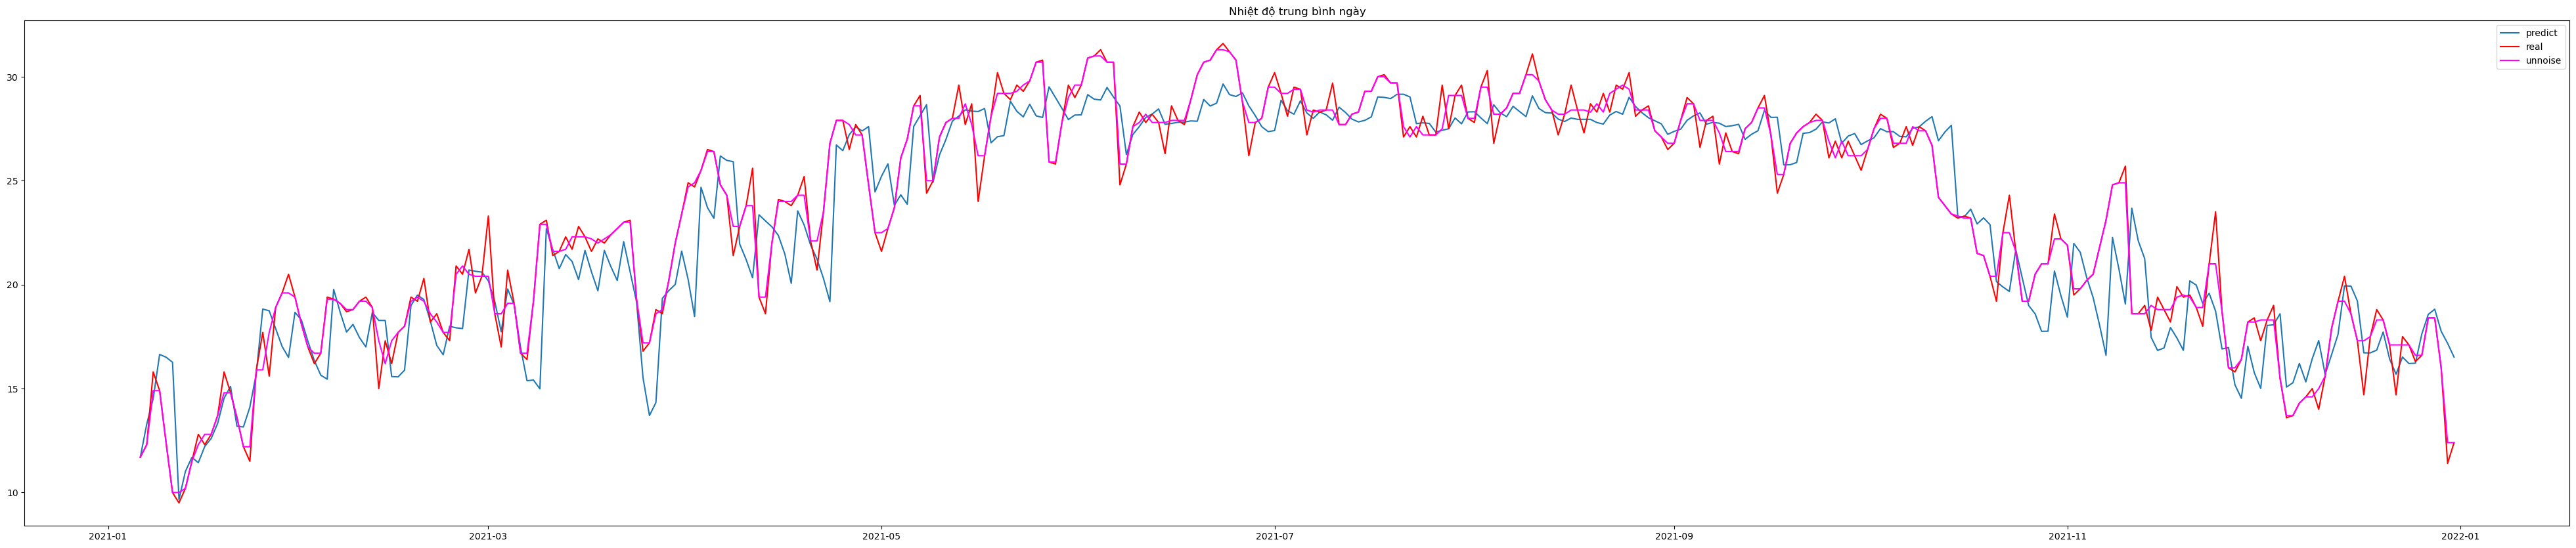

In [125]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(dataset[start_idx:end_idx].index, Ttb_pred, label='predict')
plt.plot(dataset[start_idx:end_idx].index, Ttb_real, c='red', label='real')
plt.plot(dataset[start_idx:end_idx].index, Ttb_unnoise, c='magenta', label='unnoise')
plt.title('Nhiệt độ trung bình ngày')
plt.legend();

### Tx (Nhiệt độ cao nhất)

In [126]:
# mean absolute error
Tx_mae_1 = float(mean_absolute_error(Tx_unnoise, Tx_pred))# compare with unnoise_dataset
Tx_mae_2 = float(mean_absolute_error(Tx_real, Tx_pred))# compare with real dataset
print('Độ lệch trung bình của Tx so với dữ liệu đã khử nhiễu là: {:.3f}'.format(Tx_mae_1))
print('Độ lệch trung bình của Tx so với dữ liệu thực tế là: {:.3f}'.format(Tx_mae_2))

Độ lệch trung bình của Tx so với dữ liệu đã khử nhiễu là: 1.758
Độ lệch trung bình của Tx so với dữ liệu thực tế là: 2.060


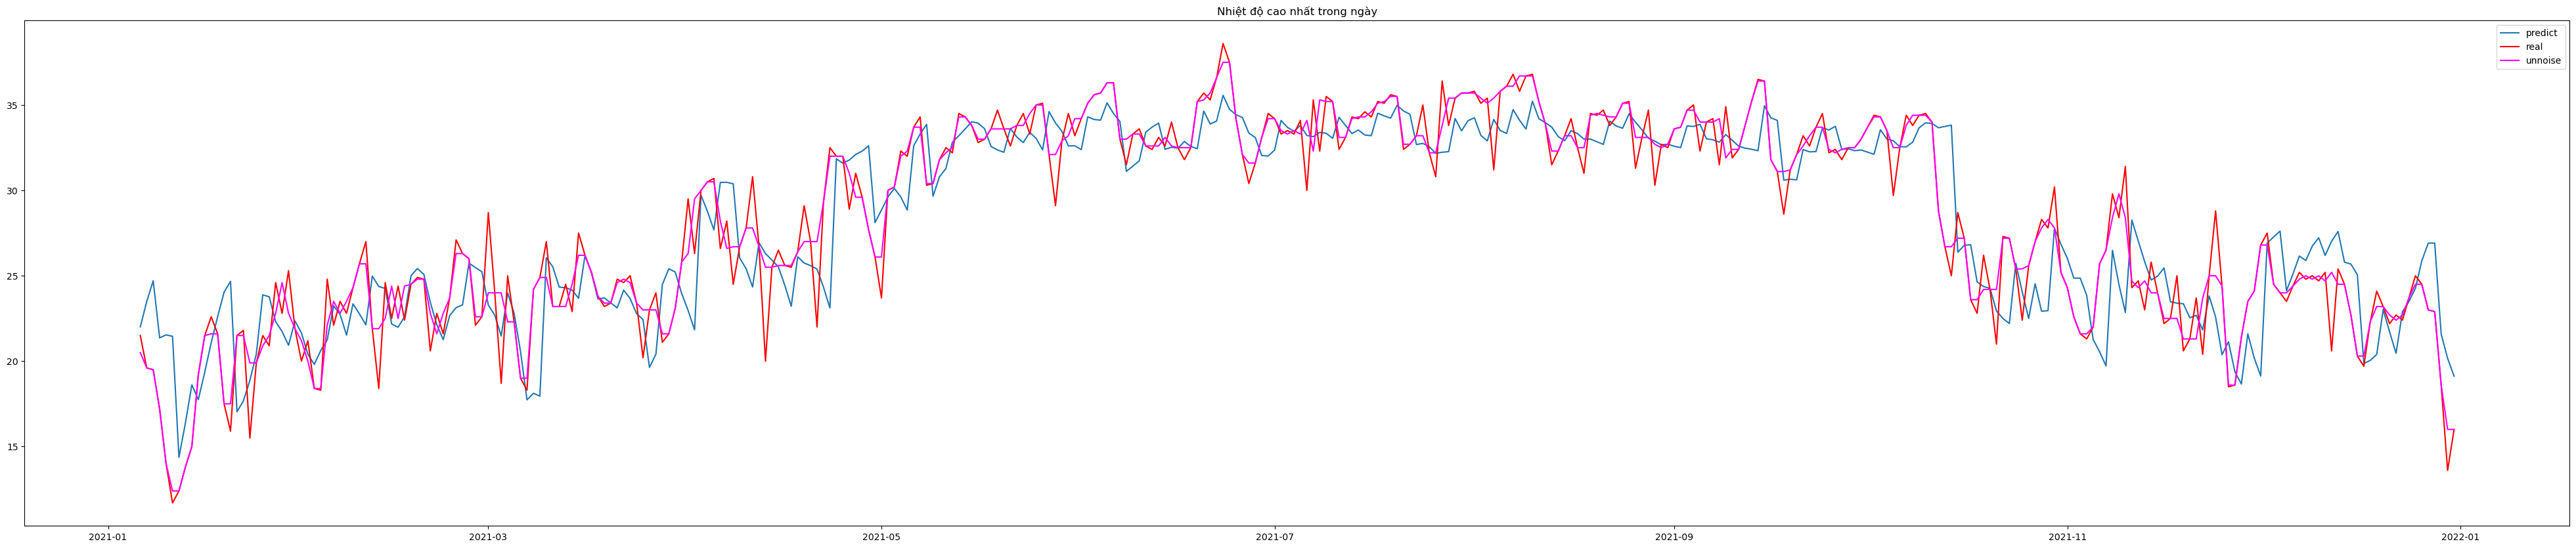

In [127]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(dataset[start_idx:end_idx].index, Tx_pred, label='predict')
plt.plot(dataset[start_idx:end_idx].index, Tx_real, c='red', label='real')
plt.plot(dataset[start_idx:end_idx].index, Tx_unnoise, c='magenta', label='unnoise')
plt.title('Nhiệt độ cao nhất trong ngày')
plt.legend();

### Tn (Nhiệt độ thấp nhất)

In [128]:
# mean absolute error
Tn_mae_1 = float(mean_absolute_error(Tn_unnoise, Tn_pred))# compare with unnoise_dataset
Tn_mae_2 = float(mean_absolute_error(Tn_real, Tn_pred))# compare with real dataset
print('Độ lệch trung bình của Tn so với dữ liệu đã khử nhiễu là: {:.3f}'.format(Tn_mae_1))
print('Độ lệch trung bình của Tn so với dữ liệu thực tế là: {:.3f}'.format(Tn_mae_2))

Độ lệch trung bình của Tn so với dữ liệu đã khử nhiễu là: 1.499
Độ lệch trung bình của Tn so với dữ liệu thực tế là: 1.632


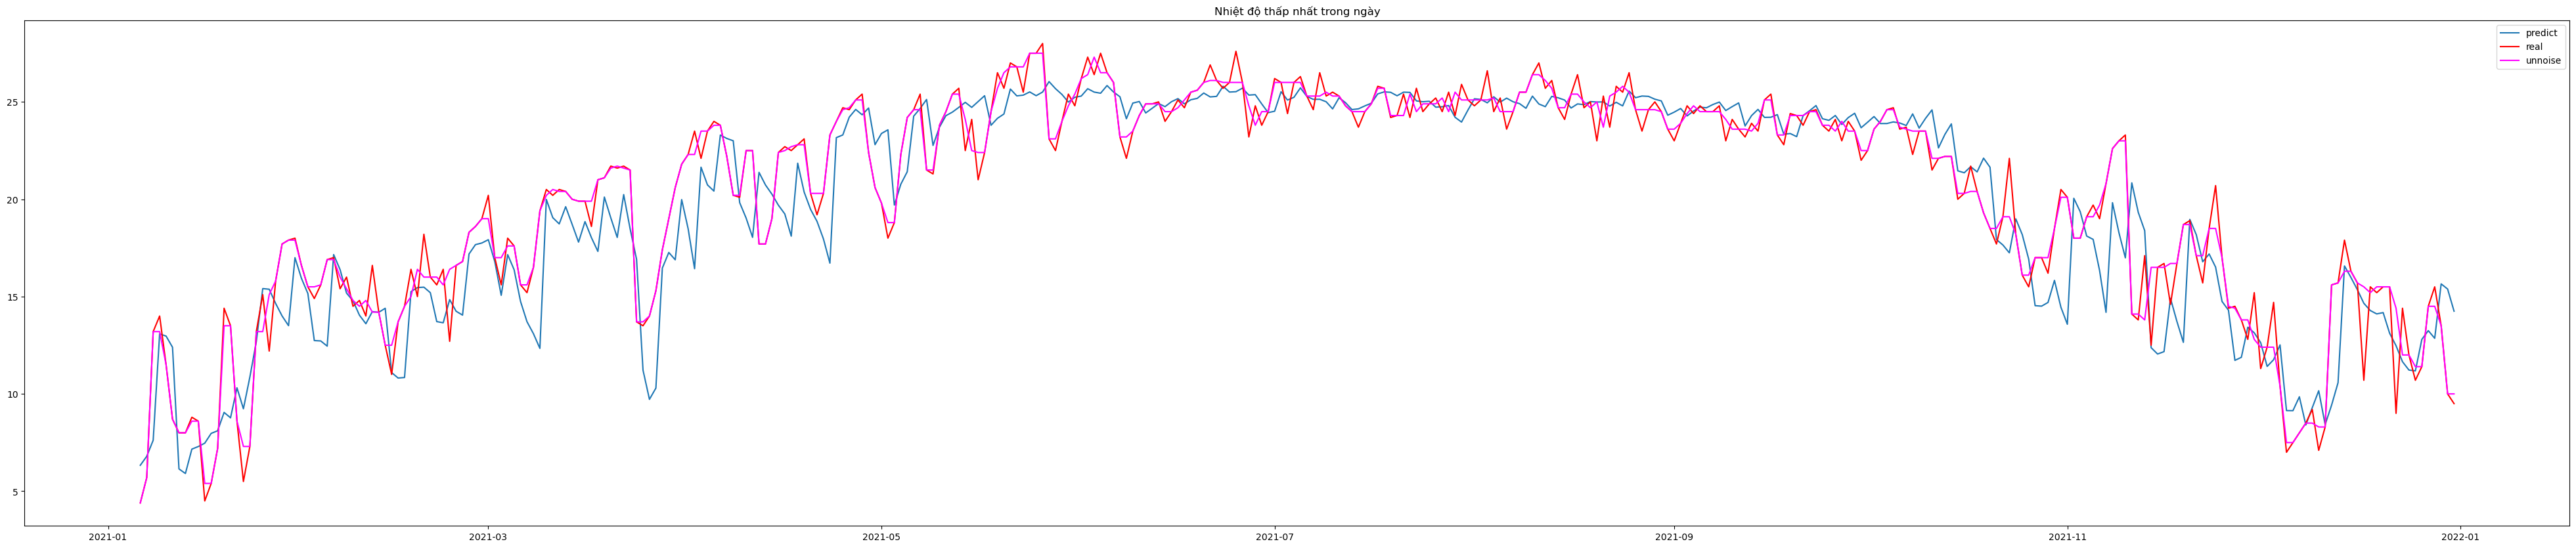

In [129]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(dataset[start_idx:end_idx].index, Tn_pred, label='predict')
plt.plot(dataset[start_idx:end_idx].index, Tn_real, c='red', label='real')
plt.plot(dataset[start_idx:end_idx].index, Tn_unnoise, c='magenta', label='unnoise')
plt.title('Nhiệt độ thấp nhất trong ngày')
plt.legend();

### Utb (Độ ẩm trung bình)

In [130]:
# mean absolute error
Utb_mae_1 = float(mean_absolute_error(Utb_unnoise, Utb_pred))# compare with unnoise_dataset
Utb_mae_2 = float(mean_absolute_error(Utb_real, Utb_pred))# compare with real dataset
print('Độ lệch trung bình của Tn so với dữ liệu đã khử nhiễu là: {:.3f}'.format(Utb_mae_1))
print('Độ lệch trung bình của Tn so với dữ liệu thực tế là: {:.3f}'.format(Utb_mae_2))

Độ lệch trung bình của Tn so với dữ liệu đã khử nhiễu là: 3.678
Độ lệch trung bình của Tn so với dữ liệu thực tế là: 4.681


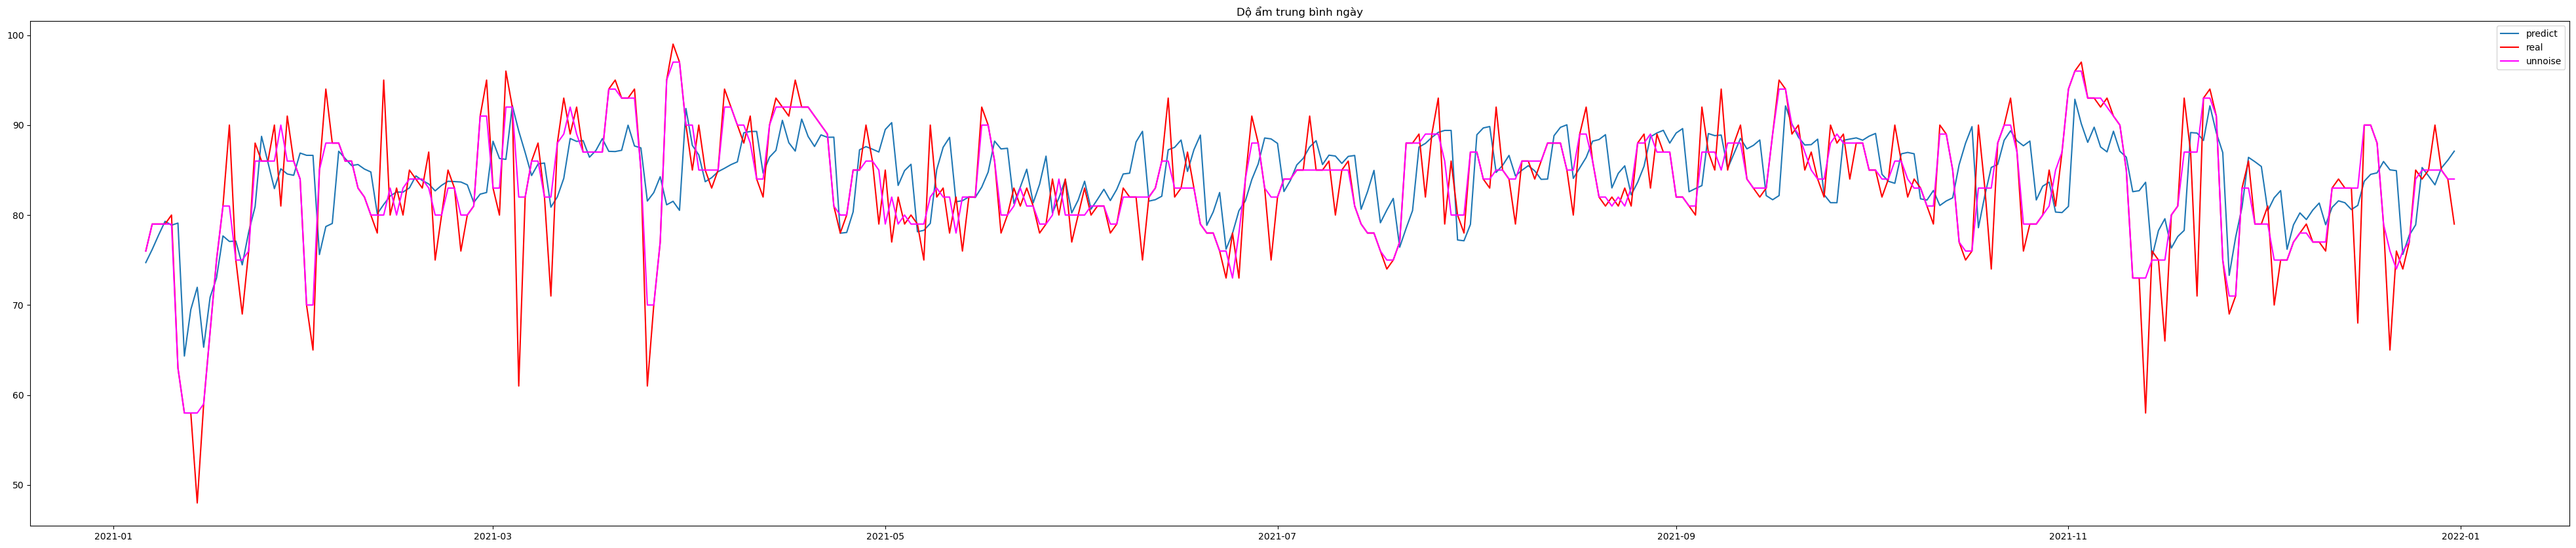

In [131]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(dataset[start_idx:end_idx].index, Utb_pred, label='predict')
plt.plot(dataset[start_idx:end_idx].index, Utb_real, c='red', label='real')
plt.plot(dataset[start_idx:end_idx].index, Utb_unnoise, c='magenta', label='unnoise')
plt.title('Dộ ẩm trung bình ngày')
plt.legend();

### Un (Độ ẩm thấp nhất)

In [132]:
# mean absolute error
Un_mae_1 = float(mean_absolute_error(Un_unnoise, Un_pred))# compare with unnoise_dataset
Un_mae_2 = float(mean_absolute_error(Un_real, Un_pred))# compare with real dataset
print('Độ lệch trung bình của Tn so với dữ liệu đã khử nhiễu là: {:.3f}'.format(Un_mae_1))
print('Độ lệch trung bình của Tn so với dữ liệu thực tế là: {:.3f}'.format(Un_mae_2))

Độ lệch trung bình của Tn so với dữ liệu đã khử nhiễu là: 6.827
Độ lệch trung bình của Tn so với dữ liệu thực tế là: 8.598


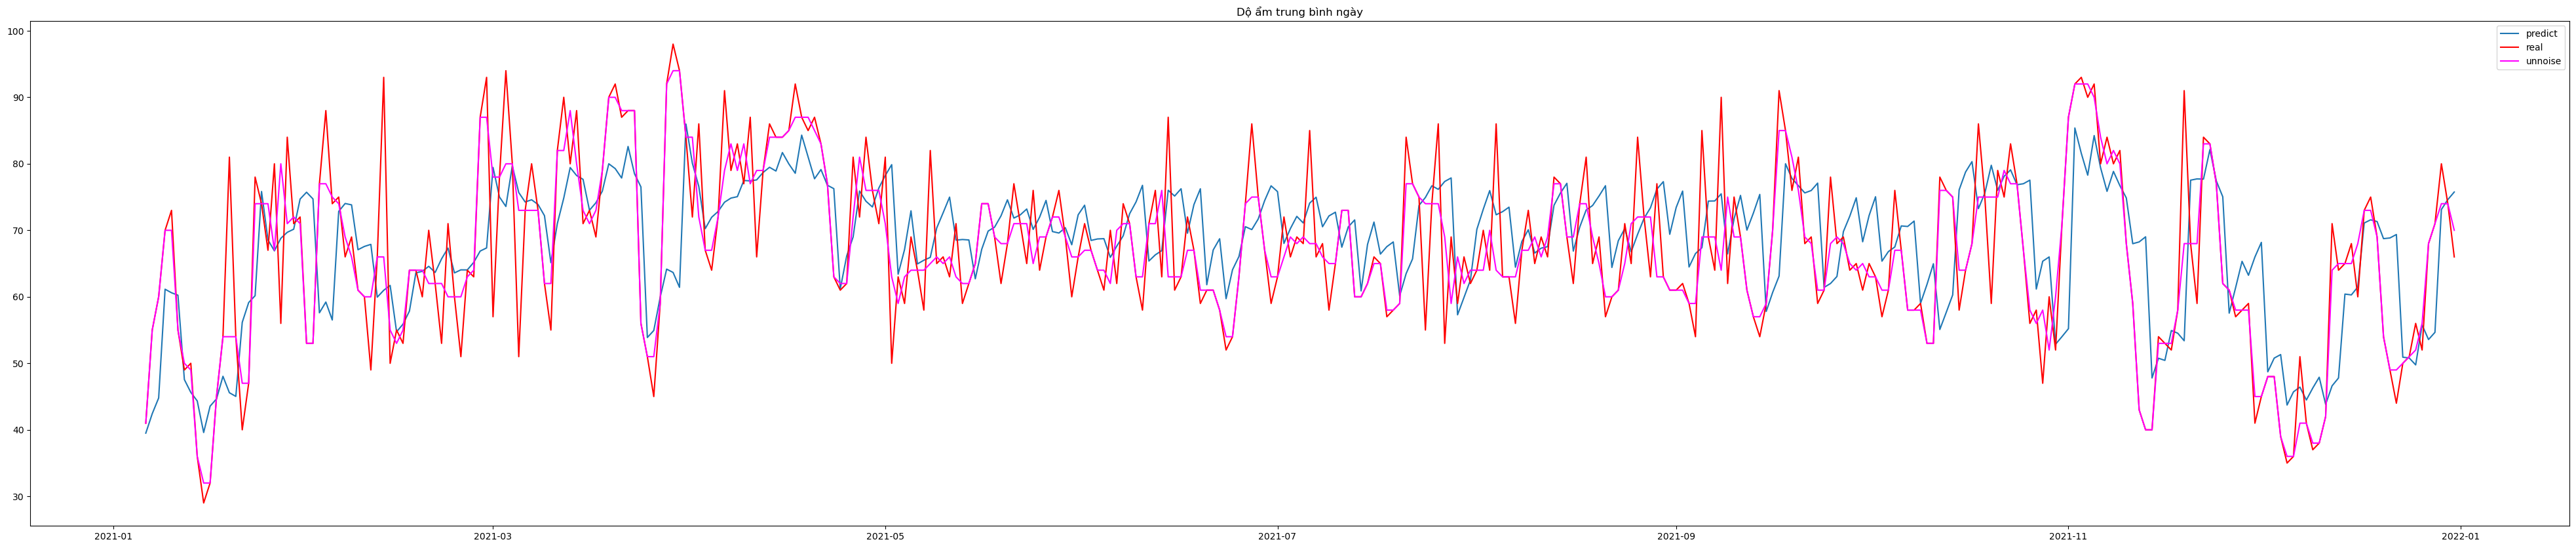

In [133]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(dataset[start_idx:end_idx].index, Un_pred, label='predict')
plt.plot(dataset[start_idx:end_idx].index, Un_real, c='red', label='real')
plt.plot(dataset[start_idx:end_idx].index, Un_unnoise, c='magenta', label='unnoise')
plt.title('Dộ ẩm trung bình ngày')
plt.legend();

### R (Mưa)

In [134]:
BA = keras.metrics.BinaryAccuracy(threshold=0.5)
BA.update_state(R_real, R_pred)
R_Accuracy = float(BA.result())
print('Độ chính xác khi dự đoán mưa hay không: {:.2f}%'.format(R_Accuracy*100))

Độ chính xác khi dự đoán mưa hay không: 64.44%


## Kết luận

In [135]:
conclusion = pd.DataFrame({
    'Predict' : ['Ttb (Nhiệt độ trung bình)', 'Tx (Nhiệt độ cao nhất)', 'Tn (Nhiệt độ thấp nhất)', 'Utb (Độ ẩm trung bình)', 'Un (Độ ẩm thấp nhất)', 'R (Mưa)'],
    'Vs_unnoise_data' : [Ttb_mae_1, Tx_mae_1, Tn_mae_1, Utb_mae_1, Un_mae_1, R_Accuracy],
    'Vs_real_data' : [Ttb_mae_2, Tx_mae_2, Tn_mae_2, Utb_mae_2, Un_mae_2, R_Accuracy]
})

In [136]:
conclusion

,Predict,Vs_unnoise_data,Vs_real_data
0,Ttb (Nhiệt độ trung bình),1.343789,1.491563
1,Tx (Nhiệt độ cao nhất),1.758367,2.059978
2,Tn (Nhiệt độ thấp nhất),1.499257,1.632046
3,Utb (Độ ẩm trung bình),3.678199,4.680957
4,Un (Độ ẩm thấp nhất),6.826656,8.598370
5,R (Mưa),0.644444,0.644444
